In [48]:
import numpy as np
import sympy
import random
import math
import matplotlib.pyplot as plt
from sympy import *
import scipy
from scipy.stats import chi2  

from scipy.stats import multivariate_t
from scipy.stats import cauchy
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
np.random.seed(5)

Coefficients: 
 [949.43526038]


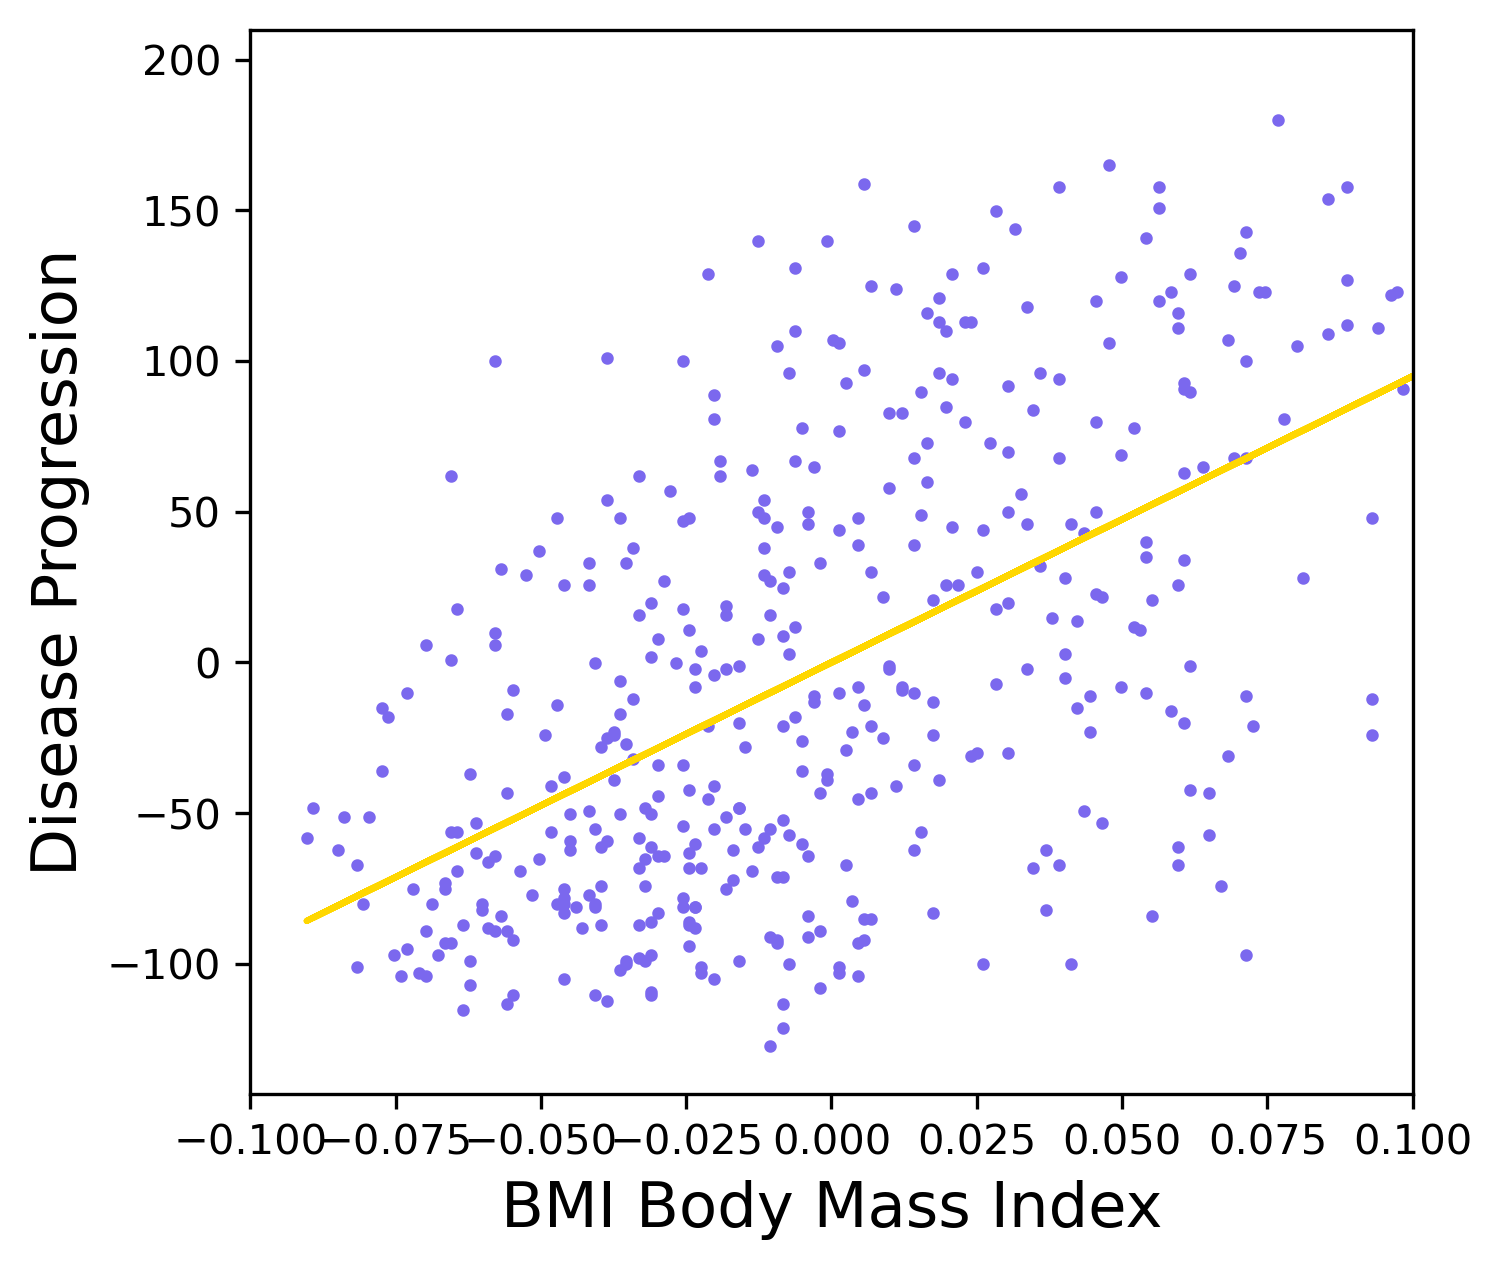

In [49]:
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)
diabetes_y = diabetes_y-diabetes_y.mean()

diabetes_X = diabetes_X[:, np.newaxis, 2]

regr = linear_model.LinearRegression()

regr.fit(diabetes_X, diabetes_y)

diabetes_y_pred = regr.predict(diabetes_X)

print("Coefficients: \n", regr.coef_)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=300,figsize=(5,4.7))
plt.scatter(diabetes_X, diabetes_y, color="mediumslateblue",s=4)
plt.plot(diabetes_X, diabetes_y_pred, color="gold", linewidth=1.5)
plt.xlim(-0.1,0.1)
plt.ylabel('Disease Progression',size=15)
plt.xlabel('BMI Body Mass Index',size=15)
plt.show()

In [50]:
a = np.zeros((len(diabetes_X),1),dtype=np.int32)
for i in range(len(a)):
    a[i] = int(i)
state = np.random.get_state()
np.random.shuffle(a)

a = a.T[0]
diabetes_X_OLS = diabetes_X[a[0:242]]
diabetes_X_inv = diabetes_X[a[242:442]]

diabetes_y_OLS = diabetes_y[a[0:242]]
diabetes_y_inv = diabetes_y[a[242:442]]

regr = linear_model.LinearRegression()

regr.fit(diabetes_X_OLS, diabetes_y_OLS)

diabetes_y_pred = regr.predict(diabetes_X_OLS)

# print("Coefficients: \n", regr.coef_)
theta0 = regr.coef_
var_est = np.linalg.norm(diabetes_y_OLS - diabetes_X_OLS * theta0,ord=2)* sqrt(1/(len(diabetes_y_OLS)-1))

In [51]:
x = diabetes_X_inv
y = diabetes_y_inv
x = x.reshape(-1,1)
y = y.reshape(-1,1)
# semi-parametric option
y = x*theta0 + np.random.normal(0,var_est,len(y)).reshape(-1,1)

In [52]:
permutation = []
K = 1000
tr_example = len(y)-1
te_example = 1
for j in range(K):
    A = np.zeros((tr_example+1,1))
    for i in range(tr_example+1):
        A[i] = i
    np.random.shuffle(A)
    permutation.append(A)

In [53]:
import time
K = 1000
alpha = 0.05
alpha1 = int((K+1) * alpha /2)
alpha2 = K + 1 - alpha1
v_num = int(K*alpha)
inf = 999999
tr_example = len(y)-1
te_example = 1
    
record = []
for cv in range(1000):
    time1 = time.time()
    print('trial:',cv)
    y = x*theta0 + np.random.normal(0,var_est,len(y)).reshape(-1,1)
    y_train = y[0:(len(y)-1)]
    y_test = y[len(y)-1]
    x_train = x[0:(len(x)-1)]
    x_test = x[len(x)-1]
    n = len(x_train)
    cs_idx = 0
    pb_idx = 0
    gau_idx = 0
    x1 = np.zeros((len(x_train)+1,1))
    for i in range(len(x1)-1):
        x1[i] = x_train[i]
    res = y_train - theta0 * x_train
    temp = np.linalg.inv(np.dot(x_train.T,x_train))
    temp = np.dot(temp,x_train.T)
    thetaols = np.dot(temp,y_train)
    for num in range(len(y_test)):
        xte = x_test[num]
        x1[len(x1)-1] = xte    
        res1 = np.concatenate([res,(y_test[num]-theta0*xte)*np.ones((1,1))])
        res1_n = res1 - np.mean(res1)*np.ones((tr_example+1,1))
        x1_n = x1 - np.mean(x1)*np.ones((tr_example+1,1))
        sum1 = np.dot(x1_n.T,res1_n)
        valid = 0
        # Permutation based
        for j in range(K):
            A = permutation[j]
            res2_n = np.ones((n+1,1))
            for idx_t in range(n+1):
                res2_n[int(A[idx_t])] = res1_n[idx_t]
            sum2 = np.dot(x1_n.T,res2_n)
            if (abs(sum1) < abs(sum2)):
                valid = valid+1
        if valid >= v_num:
            pb_idx = pb_idx + 1

        # Gaussian Pivotal JCR - \yte not in the denominator: (the other one performs really bad; and i don't want \yte on the denominator)
        def S(theta):
            s = np.linalg.norm(y_train - np.dot(x_train,theta),ord=2)
            return s
        y_u_gau = np.dot(xte,theta0) + S(thetaols) * sqrt(scipy.stats.f.ppf( .95,1,tr_example-1)) * sqrt(1/(tr_example-1))
        y_l_gau = np.dot(xte,theta0) - S(thetaols) * sqrt(scipy.stats.f.ppf( .95,1,tr_example-1)) * sqrt(1/(tr_example-1))
        if (y_test[num] < y_u_gau) & (y_test[num] > y_l_gau):
            gau_idx = gau_idx + 1
        # cyclic-shift
        K1 = tr_example+1
        alpha = 0.05
        alpha1 = int((K1+1) * alpha/2)
        alpha2 = K1  - int((K1+1) * alpha) + alpha1

        res = y_train - theta0 * x_train
        temp = np.sort(res,axis=0)
        y_l_cs = np.dot(xte,theta0) + temp[alpha1 - 1] 
        y_u_cs = np.dot(xte,theta0) + temp[alpha2 - 1] 

        if (y_test[num] < y_u_cs) & (y_test[num] > y_l_cs):
            cs_idx = cs_idx + 1
    time2 = time.time()
    print('time:',time2-time1,'s')
    temp = np.array([gau_idx/len(y_test),cs_idx/len(y_test),pb_idx/len(y_test)])
    record.append(temp)
    print(temp)

trial: 0
time: 0.2822444438934326 s
[1. 1. 1.]
trial: 1
time: 0.44290661811828613 s
[1. 1. 1.]
trial: 2
time: 0.3749973773956299 s
[1. 1. 1.]
trial: 3
time: 0.3845212459564209 s
[1. 1. 1.]
trial: 4
time: 0.43491291999816895 s
[1. 1. 1.]
trial: 5
time: 0.4059147834777832 s
[1. 1. 1.]
trial: 6
time: 0.3952057361602783 s
[1. 1. 1.]
trial: 7
time: 0.45073390007019043 s
[1. 1. 1.]
trial: 8
time: 0.5206668376922607 s
[1. 1. 1.]
trial: 9
time: 0.4119296073913574 s
[1. 1. 1.]
trial: 10
time: 0.41502857208251953 s
[1. 1. 1.]
trial: 11
time: 0.4827921390533447 s
[1. 1. 1.]
trial: 12
time: 0.38585472106933594 s
[1. 1. 1.]
trial: 13
time: 0.4124941825866699 s
[1. 1. 1.]
trial: 14
time: 0.4468050003051758 s
[1. 1. 1.]
trial: 15
time: 0.3856015205383301 s
[1. 1. 1.]
trial: 16
time: 0.46779966354370117 s
[1. 1. 1.]
trial: 17
time: 0.41788315773010254 s
[1. 1. 1.]
trial: 18
time: 0.4278564453125 s
[1. 1. 1.]
trial: 19
time: 0.42342257499694824 s
[1. 1. 1.]
trial: 20
time: 0.4503607749938965 s
[1. 1. 1

time: 0.4758567810058594 s
[1. 1. 1.]
trial: 170
time: 0.4967324733734131 s
[1. 1. 1.]
trial: 171
time: 0.4303574562072754 s
[1. 1. 1.]
trial: 172
time: 0.4083688259124756 s
[1. 1. 1.]
trial: 173
time: 0.5210127830505371 s
[1. 1. 1.]
trial: 174
time: 0.39148783683776855 s
[1. 1. 1.]
trial: 175
time: 0.411898136138916 s
[1. 1. 1.]
trial: 176
time: 0.5365116596221924 s
[1. 1. 1.]
trial: 177
time: 0.47373247146606445 s
[1. 1. 1.]
trial: 178
time: 0.41303014755249023 s
[1. 1. 1.]
trial: 179
time: 0.39893341064453125 s
[1. 1. 1.]
trial: 180
time: 0.38605737686157227 s
[1. 1. 1.]
trial: 181
time: 0.4254188537597656 s
[1. 1. 1.]
trial: 182
time: 0.40491747856140137 s
[0. 0. 1.]
trial: 183
time: 0.4669308662414551 s
[1. 1. 1.]
trial: 184
time: 0.4717385768890381 s
[1. 1. 1.]
trial: 185
time: 0.4251134395599365 s
[1. 1. 1.]
trial: 186
time: 0.5555133819580078 s
[1. 1. 1.]
trial: 187
time: 0.5721616744995117 s
[1. 1. 1.]
trial: 188
time: 0.4798600673675537 s
[1. 1. 1.]
trial: 189
time: 0.4155182

time: 0.435028076171875 s
[1. 1. 1.]
trial: 337
time: 0.40691256523132324 s
[1. 1. 1.]
trial: 338
time: 0.42582201957702637 s
[1. 1. 1.]
trial: 339
time: 0.39948058128356934 s
[1. 1. 1.]
trial: 340
time: 0.3999309539794922 s
[1. 1. 1.]
trial: 341
time: 0.40099000930786133 s
[1. 1. 1.]
trial: 342
time: 0.3969390392303467 s
[0. 0. 1.]
trial: 343
time: 0.381070613861084 s
[1. 1. 1.]
trial: 344
time: 0.3835279941558838 s
[1. 1. 1.]
trial: 345
time: 0.41289639472961426 s
[1. 1. 1.]
trial: 346
time: 0.4330260753631592 s
[1. 1. 1.]
trial: 347
time: 0.37898683547973633 s
[1. 1. 1.]
trial: 348
time: 0.45409202575683594 s
[1. 1. 1.]
trial: 349
time: 0.4257791042327881 s
[1. 1. 1.]
trial: 350
time: 0.3974745273590088 s
[0. 0. 1.]
trial: 351
time: 0.39798426628112793 s
[1. 1. 1.]
trial: 352
time: 0.39394617080688477 s
[1. 1. 1.]
trial: 353
time: 0.41304540634155273 s
[1. 1. 0.]
trial: 354
time: 0.4014894962310791 s
[1. 1. 1.]
trial: 355
time: 0.410933256149292 s
[1. 1. 1.]
trial: 356
time: 0.40346

time: 0.43982434272766113 s
[1. 1. 1.]
trial: 503
time: 0.4863114356994629 s
[1. 1. 1.]
trial: 504
time: 0.3944883346557617 s
[1. 1. 1.]
trial: 505
time: 0.480926513671875 s
[1. 1. 1.]
trial: 506
time: 0.47780275344848633 s
[1. 1. 1.]
trial: 507
time: 0.5018665790557861 s
[1. 1. 1.]
trial: 508
time: 0.5038230419158936 s
[1. 1. 1.]
trial: 509
time: 0.42035436630249023 s
[1. 1. 1.]
trial: 510
time: 0.4118926525115967 s
[1. 1. 1.]
trial: 511
time: 0.4218719005584717 s
[1. 1. 1.]
trial: 512
time: 0.4249856472015381 s
[1. 1. 1.]
trial: 513
time: 0.4024696350097656 s
[1. 1. 1.]
trial: 514
time: 0.40547800064086914 s
[1. 1. 1.]
trial: 515
time: 0.4034855365753174 s
[1. 1. 1.]
trial: 516
time: 0.40491747856140137 s
[1. 1. 1.]
trial: 517
time: 0.4409186840057373 s
[1. 1. 1.]
trial: 518
time: 0.3889601230621338 s
[1. 1. 1.]
trial: 519
time: 0.38457226753234863 s
[1. 1. 0.]
trial: 520
time: 0.4229271411895752 s
[1. 1. 1.]
trial: 521
time: 0.4009270668029785 s
[1. 1. 1.]
trial: 522
time: 0.4175217

time: 0.48277759552001953 s
[1. 1. 1.]
trial: 670
time: 0.43091487884521484 s
[1. 1. 1.]
trial: 671
time: 0.5880892276763916 s
[1. 1. 1.]
trial: 672
time: 0.5153689384460449 s
[1. 1. 1.]
trial: 673
time: 0.49208855628967285 s
[1. 1. 1.]
trial: 674
time: 0.423541784286499 s
[1. 1. 0.]
trial: 675
time: 0.47492432594299316 s
[1. 1. 1.]
trial: 676
time: 0.5043625831604004 s
[1. 1. 1.]
trial: 677
time: 0.43483710289001465 s
[1. 1. 1.]
trial: 678
time: 0.3999307155609131 s
[1. 1. 1.]
trial: 679
time: 0.4464590549468994 s
[1. 1. 1.]
trial: 680
time: 0.4418187141418457 s
[1. 1. 1.]
trial: 681
time: 0.4868583679199219 s
[1. 1. 1.]
trial: 682
time: 0.4034433364868164 s
[1. 1. 1.]
trial: 683
time: 0.3931396007537842 s
[0. 0. 1.]
trial: 684
time: 0.415485143661499 s
[1. 1. 1.]
trial: 685
time: 0.4199647903442383 s
[1. 1. 1.]
trial: 686
time: 0.41202449798583984 s
[1. 1. 1.]
trial: 687
time: 0.4747302532196045 s
[1. 1. 1.]
trial: 688
time: 0.4563746452331543 s
[1. 1. 1.]
trial: 689
time: 0.39906144

time: 0.4429781436920166 s
[1. 1. 1.]
trial: 836
time: 0.40990471839904785 s
[1. 1. 1.]
trial: 837
time: 0.43111419677734375 s
[1. 1. 0.]
trial: 838
time: 0.40453219413757324 s
[1. 1. 1.]
trial: 839
time: 0.3900578022003174 s
[1. 1. 1.]
trial: 840
time: 0.38251566886901855 s
[1. 1. 1.]
trial: 841
time: 0.40337228775024414 s
[0. 0. 1.]
trial: 842
time: 0.4281480312347412 s
[1. 1. 0.]
trial: 843
time: 0.4533500671386719 s
[1. 1. 1.]
trial: 844
time: 0.43560051918029785 s
[1. 1. 1.]
trial: 845
time: 0.48360538482666016 s
[1. 1. 1.]
trial: 846
time: 0.44379305839538574 s
[1. 1. 1.]
trial: 847
time: 0.43062281608581543 s
[1. 1. 1.]
trial: 848
time: 0.3979356288909912 s
[1. 1. 1.]
trial: 849
time: 0.44593381881713867 s
[1. 1. 1.]
trial: 850
time: 0.3700108528137207 s
[1. 1. 1.]
trial: 851
time: 0.41794586181640625 s
[1. 1. 1.]
trial: 852
time: 0.39455676078796387 s
[1. 1. 1.]
trial: 853
time: 0.4338409900665283 s
[1. 1. 1.]
trial: 854
time: 0.452329158782959 s
[1. 1. 1.]
trial: 855
time: 0.3

In [54]:
record1 = np.matrix(record)
print(np.mean(record1[:,0]),np.mean(record1[:,1]),np.mean(record1[:,2]))

0.942 0.941 0.943


In [45]:
#high-dimensional
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)
diabetes_X =  np.concatenate([diabetes_X,np.ones((len(diabetes_X),1))],axis=1)

regr = linear_model.LinearRegression()

regr.fit(diabetes_X, diabetes_y)

a = np.zeros((len(diabetes_X),1),dtype=np.int32)
for i in range(len(a)):
    a[i] = int(i)
state = np.random.get_state()
np.random.shuffle(a)

a = a.T[0]
diabetes_X_OLS = diabetes_X[a[0:242]]
diabetes_X_inv = diabetes_X[a[242:442]]

diabetes_y_OLS = diabetes_y[a[0:242]]
diabetes_y_inv = diabetes_y[a[242:442]]

regr = linear_model.LinearRegression()

regr.fit(diabetes_X_OLS, diabetes_y_OLS)

diabetes_y_pred = regr.predict(diabetes_X_OLS)

# print("Coefficients: \n", regr.coef_)
theta0 = regr.coef_
# var_est = np.linalg.norm(diabetes_y_OLS - np.dot(diabetes_X_OLS, theta0.reshape(-1,1)),ord=2)* sqrt(1/(len(diabetes_y_OLS)-1))
var_est = 1

In [47]:
record = []
for epo in range(1000):
#     print(epo)
    cv = 0
    diabetes_y_inv = np.dot(diabetes_X_inv,theta0.reshape(-1,1)) + np.random.normal(0,var_est,len(diabetes_y_inv)).reshape(-1,1) + regr.intercept_*np.ones((len(diabetes_y_inv),1))
    x_train = diabetes_X_inv[0:(len(diabetes_X_inv)-1)]
    x_test = diabetes_X_inv[len(diabetes_X_inv)-1]
    y_train = diabetes_y_inv[0:(len(diabetes_y_inv)-1)]
    y_test = diabetes_y_inv[len(diabetes_y_inv)-1]

    n = len(x_train)
    p = 10+1
    c = np.zeros((p,1))
    c[0] = 1
    temp = np.linalg.inv(np.dot(x_train.T,x_train))
    temp = np.dot(temp,x_train.T)
    thetaols = np.dot(temp,y_train) 
    x1 = diabetes_X_inv
    yte = y_test
    for te_idx in range(len(y_test)):
        x1 = diabetes_X_inv
        yte = y_test

        temp2 = np.dot(c.T,np.linalg.inv(np.dot(x1.T,x1)))
        w = np.dot(temp2,x1.T)

        temp3 = (theta0[0] - np.dot(w.T[0:n].T,y_train) + np.linalg.norm(y_train - np.dot(x_train,thetaols),ord=2) * np.linalg.norm(w,ord=2)*(scipy.stats.t.ppf( .975,n-p)) * sqrt(1/(n-p)))/w.T[n]
        temp4 = (theta0[0] - np.dot(w.T[0:n].T,y_train) + np.linalg.norm(y_train - np.dot(x_train,thetaols),ord=2) * np.linalg.norm(w,ord=2)*(scipy.stats.t.ppf( .025,n-p)) * sqrt(1/(n-p)))/w.T[n]
        if temp3 > temp4:
            pred_cl_u = temp3
            pred_cl_l = temp4
        else:
            pred_cl_u = temp4
            pred_cl_l = temp3
        if (yte < pred_cl_u) & (yte > pred_cl_l):
            cv = cv + 1
    cv = cv/len(y_test)
    record.append(cv)
#     print(cv)
print(np.mean(record))

0.951
